# 1. Introduction

Name: Sifra Hilda Juliana Siregar

Dataset: Kaggle - apple_twitter_sentiment_texts

Objectives:  To develop a model that can reliably identify and classify the sentiment of tweets related to Apple, and to use these insights to enhance customer satisfaction and inform product development strategies.



# 2. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from nltk import FreqDist, bigrams, trigrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS

from function import text_preprocessing
import re

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import warnings
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sifrasiregar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sifrasiregar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 3. Data Loading

## A. Warning Filters

In [3]:
warnings.filterwarnings('ignore')

## B. Import Data

In [4]:
#read data from csv
data = pd.read_csv('apple-twitter-sentiment-texts.csv')
data

,text,sentiment
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1
1,What Happened To Apple Inc? http://t.co/FJEX...,0
2,Thank u @apple I can now compile all of the pi...,1
3,The oddly uplifting story of the Apple co-foun...,0
4,@apple can i exchange my iphone for a differen...,0
...,...,...
1625,Those** PICK UP THE SLACK YOU FUCK BOYS @Apple,-1
1626,Finally got my iPhone 6 in the mail and it com...,-1
1627,@umo_games @Apple ended up getting a new compu...,0
1628,The 19-Year-Old #WizKid Who Turned Down @Apple...,0


# 4. EDA

## A. Data Inspection

In [5]:
#check data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1630 non-null   object
 1   sentiment  1630 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 25.6+ KB


In [6]:
#check data shape
data.shape

(1630, 2)

This dataset has 1630 rows and 2 columns

In [7]:
#check missing values
data.isnull().sum()

text         0
sentiment    0
dtype: int64

There is no misssing value on this dataset

In [8]:
#check duplicated data
data.duplicated().sum()

6

It has 6 duplicated data on this dataset

## B. Text Analysis

In [9]:
#check text length
len(data['text'])

1630

There are 1630 individual text items in the data.

In [10]:
from nltk import FreqDist, bigrams, trigrams
#check word frequency
words = [word for text in data['text'].dropna() for word in word_tokenize(text.lower())]

#frequency distribution
word_freq = FreqDist(words)

# show the 10 most common words
print(word_freq.most_common(10))

[('@', 2080), ('apple', 1713), ('#', 1623), (':', 1265), ('http', 820), ('.', 700), ('aapl', 524), ('the', 512), ('to', 504), (',', 499)]


In [11]:
#check common bigrams and trigrams

# bigrams
bigram_freq = FreqDist(bigrams(words))
print("Most Common Bigrams:", bigram_freq.most_common(10))

# trigrams
trigram_freq = FreqDist(trigrams(words))
print("Most Common Trigrams:", trigram_freq.most_common(10))

Most Common Bigrams: [(('@', 'apple'), 1230), (('http', ':'), 820), (('#', 'aapl'), 396), (('aapl', 'http'), 174), (('aapl', '#'), 163), (('#', 'apple'), 162), (('rt', '@'), 155), (('apple', '@'), 131), (('apple', '#'), 130), (('$', 'aapl'), 114)]
Most Common Trigrams: [(('#', 'aapl', 'http'), 174), (('aapl', 'http', ':'), 174), (('@', 'apple', '@'), 123), (('$', 'aapl', '#'), 108), (('aapl', '#', 'aapl'), 108), (('@', 'apple', '#'), 97), (('.', '@', 'apple'), 77), (('...', 'http', ':'), 75), (('&', 'amp', ';'), 61), (('!', '!', '!'), 60)]


## C. Visualisation

### a. Visualisation of Average Text Length by Sentiment

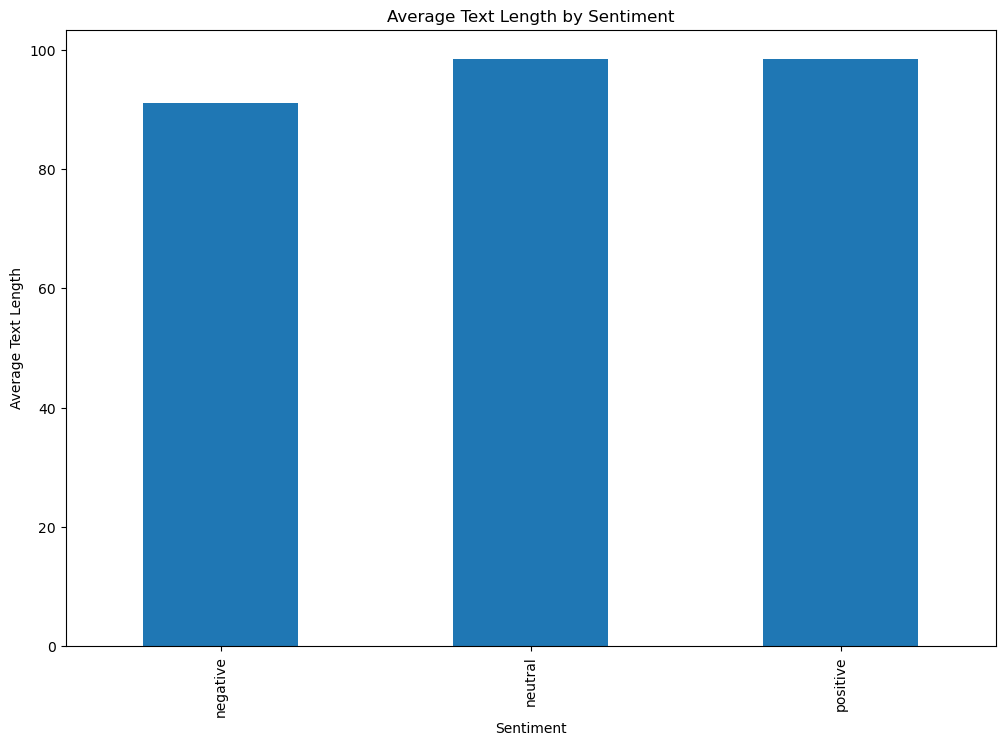

In [12]:

data['text_length'] = data['text'].apply(len)
plt.figure(figsize=(12,8))
data.groupby('sentiment')['text_length'].mean().plot(kind='bar')
sentiment_labels = {-1: 'negative', 0: 'neutral', 1: 'positive'}
plt.xticks(range(len(sentiment_labels)), sentiment_labels.values(), rotation=90)

plt.title('Average Text Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Text Length')
plt.show()

From this bar chart, it shows the negative sentiment on average have less text length than neutral and positve sentiment.

### b. Percentage of Different Sentiment of Tweets

In [13]:
data['sentiment'].value_counts()

sentiment
 0    801
-1    686
 1    143
Name: count, dtype: int64

In [14]:
fig = px.pie(data, names='sentiment', title ='Pie chart of different sentiments of tweets')
fig.show()

This is a visualisation of a pie chart representing the percentage of the different sentiments of tweets;

- Negative: 42.1%

- Neutral: 49.1%

- Positive: 8.77%.

# 5. FE

## A. Drop Duplicates 

In [15]:
data=data.drop_duplicates(keep=False)
data.duplicated().sum()

0

## B. Text Preprocessing

In [16]:
#stop words initialization
stop_words =set(stopwords.words('english'))

#porter stemmer initialization
stemmer = PorterStemmer()

In [17]:
#pre-process text for the model
data['text_processed'] = data['text'].apply(lambda x: text_preprocessing(x, stemmer, stop_words))
data

,text,sentiment,text_length,text_processed
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1,105,wow yall needa step rt music snapchat damn tim...
1,What Happened To Apple Inc? http://t.co/FJEX...,0,101,happen appl inc
2,Thank u @apple I can now compile all of the pi...,1,108,thank u compil pic commun one place
3,The oddly uplifting story of the Apple co-foun...,0,115,oddli uplift stori appl co founder sold stake ...
4,@apple can i exchange my iphone for a differen...,0,77,exchang iphon differ color lmao chang mind
...,...,...,...,...
1625,Those** PICK UP THE SLACK YOU FUCK BOYS @Apple,-1,46,pick slack fuck boy
1626,Finally got my iPhone 6 in the mail and it com...,-1,100,final got iphon mail come box bust screen thank
1627,@umo_games @Apple ended up getting a new compu...,0,139,end get new comput anyhow work comput 's switc...
1628,The 19-Year-Old #WizKid Who Turned Down @Apple...,0,111,year old turn nab back star


Using the `text_preprocessing` from `function.py` to process the data. 

In [18]:
#convert the sentiment values from one scale to another
def change_sentiment(value):
    if value == 0:
        return 1
    elif value == 1:
        return 2
    else:
        return 0

data['label'] = data['sentiment'].map(change_sentiment)
data

,text,sentiment,text_length,text_processed,label
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1,105,wow yall needa step rt music snapchat damn tim...,0
1,What Happened To Apple Inc? http://t.co/FJEX...,0,101,happen appl inc,1
2,Thank u @apple I can now compile all of the pi...,1,108,thank u compil pic commun one place,2
3,The oddly uplifting story of the Apple co-foun...,0,115,oddli uplift stori appl co founder sold stake ...,1
4,@apple can i exchange my iphone for a differen...,0,77,exchang iphon differ color lmao chang mind,1
...,...,...,...,...,...
1625,Those** PICK UP THE SLACK YOU FUCK BOYS @Apple,-1,46,pick slack fuck boy,0
1626,Finally got my iPhone 6 in the mail and it com...,-1,100,final got iphon mail come box bust screen thank,0
1627,@umo_games @Apple ended up getting a new compu...,0,139,end get new comput anyhow work comput 's switc...,1
1628,The 19-Year-Old #WizKid Who Turned Down @Apple...,0,111,year old turn nab back star,1


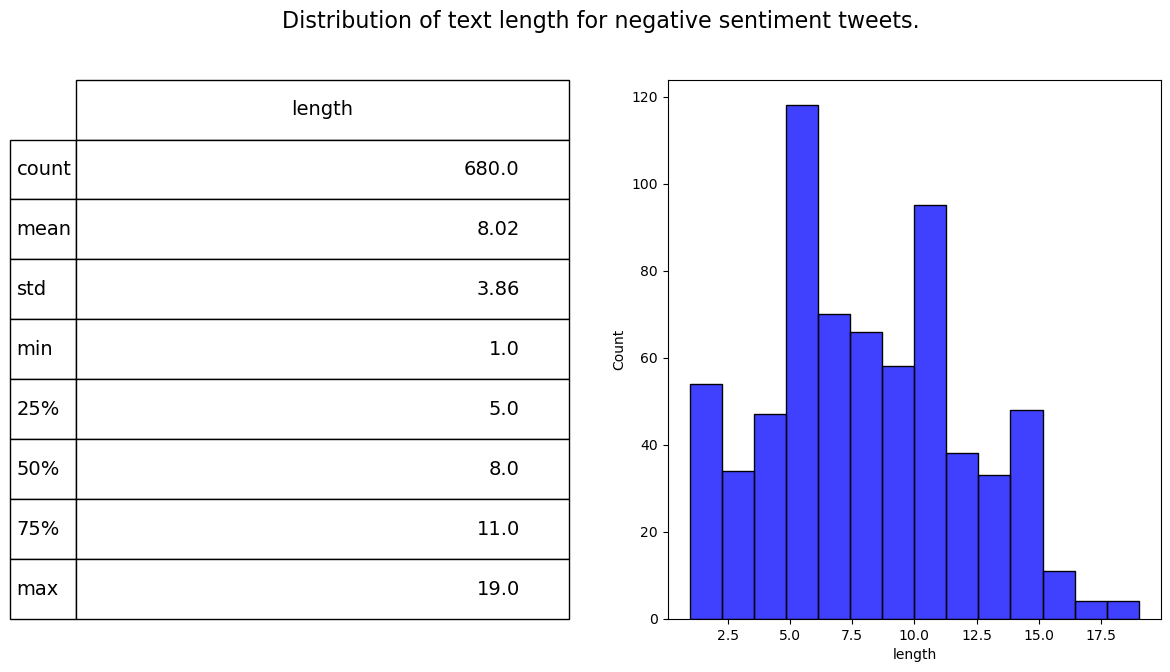

In [19]:
#plotting the distribution of text length for negative sentiment tweets
fig = plt.figure(figsize=(14,7))
data['length'] = data.text_processed.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(data[data['sentiment']==-1]['length'], ax=ax1,color='blue')
describe = data.length[data.sentiment==-1].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for negative sentiment tweets.', fontsize=16)

plt.show()

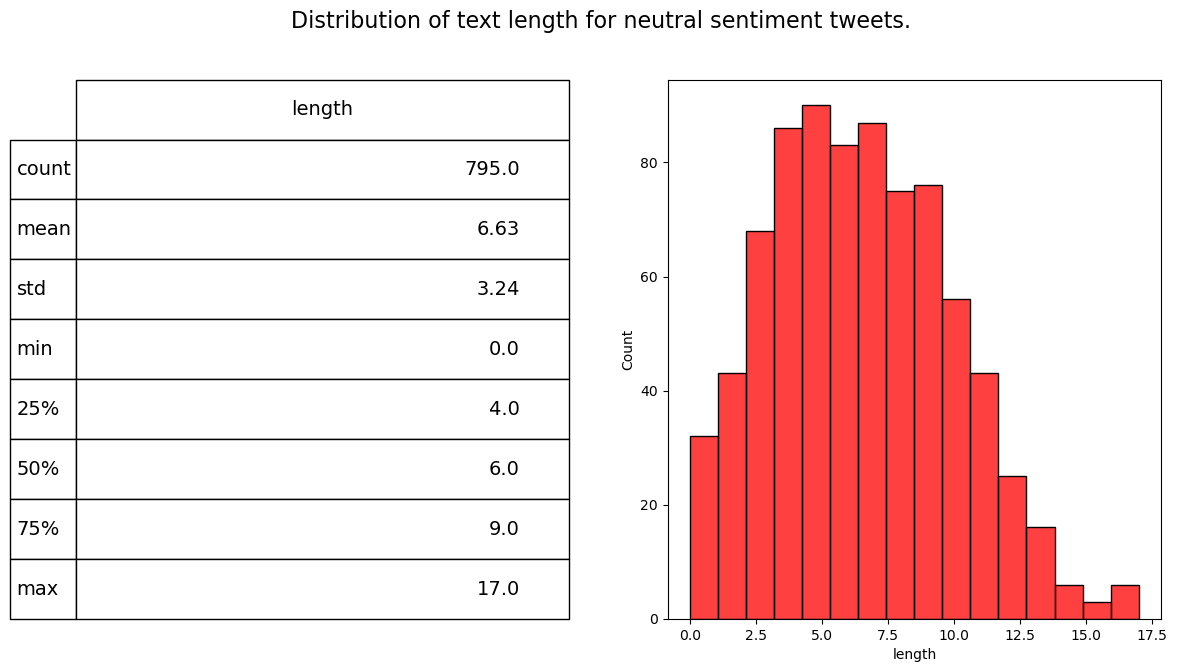

In [20]:
#plotting the distribution of text length for neutral sentiment tweets
fig = plt.figure(figsize=(14,7))
data['length'] = data.text_processed.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(data[data['sentiment']==0]['length'], ax=ax1,color='red')
describe = data.length[data.sentiment==0].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for neutral sentiment tweets.', fontsize=16)

plt.show()

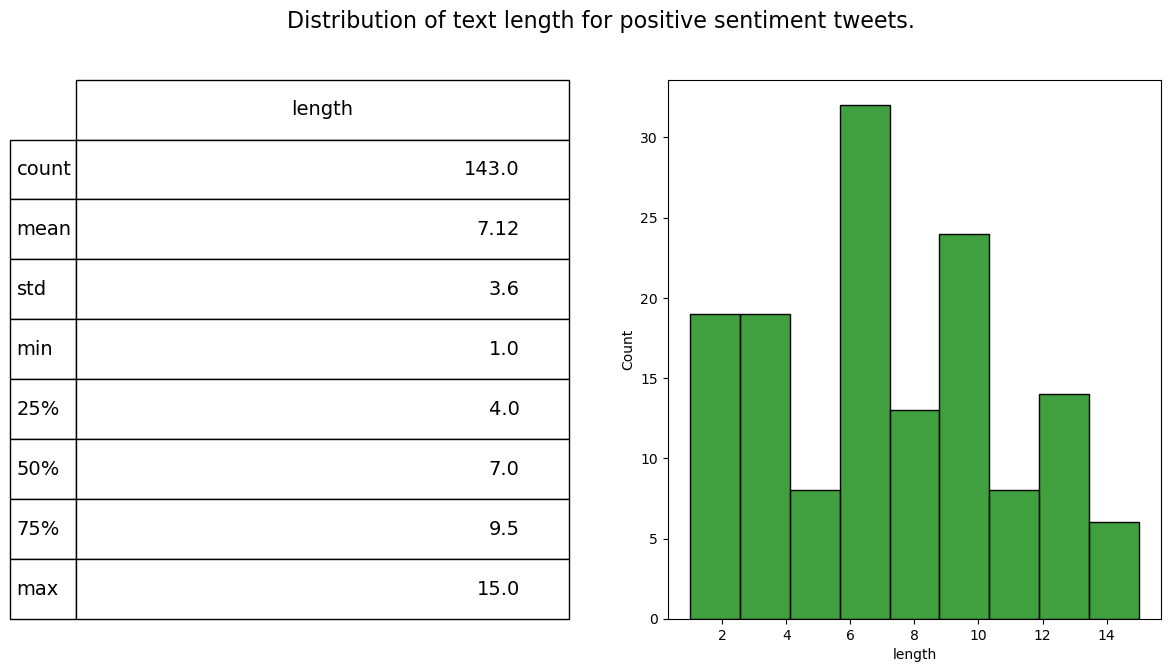

In [21]:
#plotting the distribution of text length for positive sentiment tweets
fig = plt.figure(figsize=(14,7))
data['length'] = data.text_processed.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(data[data['sentiment']==1]['length'], ax=ax1,color='green')
describe = data.length[data.sentiment==1].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

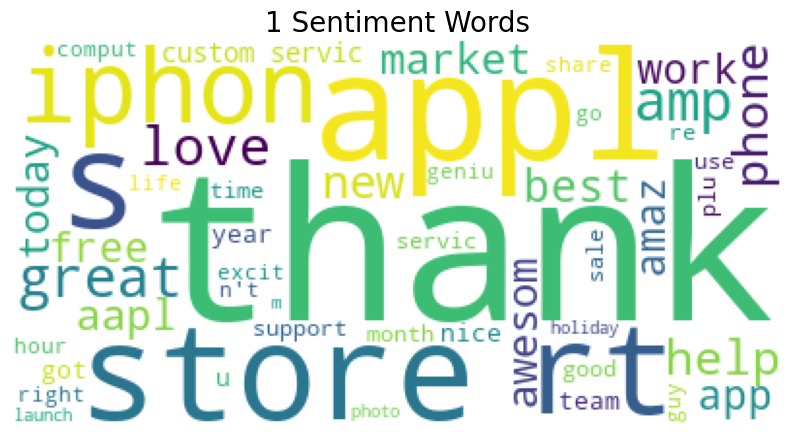

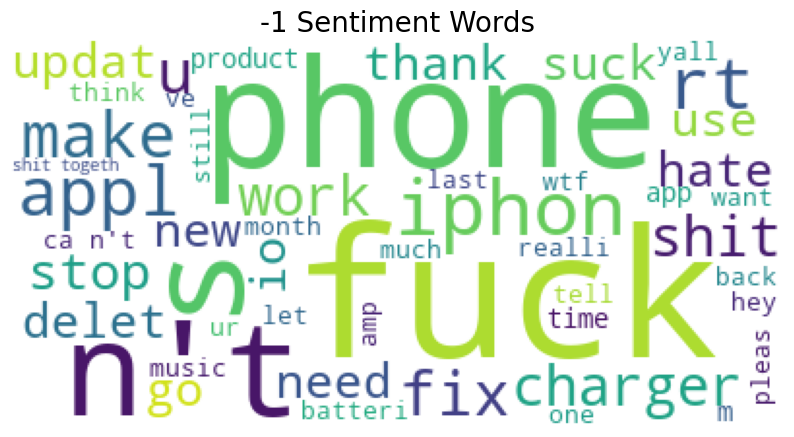

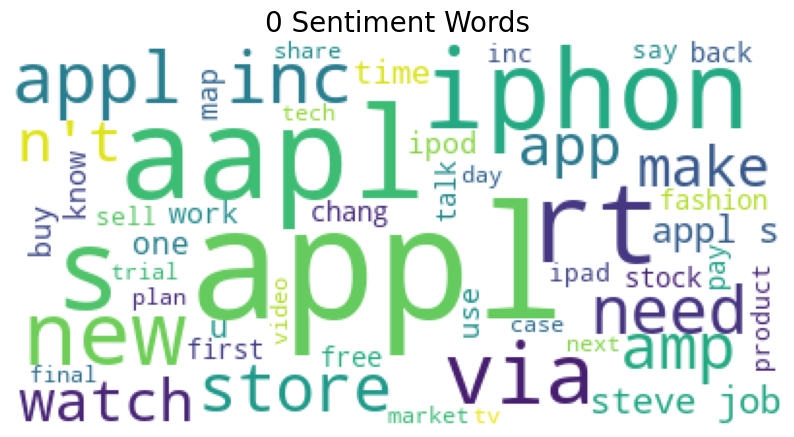

In [22]:
#visualizing data into wordcount
def wordcount_gen(data, sentiment):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - category: Positive/Negative/Neutral
    '''
    
    combined_tweets = " ".join([tweet for tweet in data[data.sentiment==sentiment]['text_processed']])

    wc = WordCloud(background_color='white',
                   max_words=50,
                   stopwords = STOPWORDS)

    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(sentiment), fontsize=20)
    plt.axis('off')
    plt.show()

# Positive tweet words
wordcount_gen(data, 1)

# Negative tweet words
wordcount_gen(data, -1)

# Neutral tweet words
wordcount_gen(data, 0)


## C. Split Data

In [23]:
# data splitting
X_train_val, X_test, y_train_val, y_test = train_test_split(data.text_processed,
                                                    data.label,
                                                    test_size=0.15,
                                                    random_state=20,
                                                    stratify=data.label)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (1237,)
Val Size   :  (138,)
Test Size  :  (243,)


## D. One Hot Encoding

In [24]:
y_train_ohe = to_categorical(y_train, num_classes=3)
y_val_ohe = to_categorical(y_val, num_classes=3)
y_test_ohe = to_categorical(y_test, num_classes=3)
y_train_ohe

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

## E. Vectorization

In [25]:
# vocabularies
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<1237x2275 sparse matrix of type '<class 'numpy.int64'>'
	with 8297 stored elements in Compressed Sparse Row format>

In [26]:
# vocab and sentence length

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  2275
Maximum Sentence Length :  19 tokens


In [27]:
# text vectorization
text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

In [28]:
# the top 20 tokens

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'appl',
 's',
 'iphon',
 'nt',
 'rt',
 'fuck',
 'phone',
 'aapl',
 'new',
 'get',
 'app',
 'make',
 'store',
 'thank',
 'amp',
 'shit',
 'updat',
 'need']

## F. Embedding

In [29]:
# Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

## G. Results

In [30]:
## Document example
print('Document example')
print(data.text_processed[0])
print('')

## Result of Text Vectorization
print('Result of  Text Vectorization')
print(text_vectorization([data.text_processed[0]]))
print('Vector size : ', text_vectorization([data.text_processed[0]]).shape)
print('')

## Result of  Embedding
print('Result of  Embedding')
print(embedding(text_vectorization([data.text_processed[0]])))
print('Vector size : ', embedding(text_vectorization([data.text_processed[0]])).shape)

Document example
wow yall needa step rt music snapchat damn time thank

Result of  Text Vectorization
tf.Tensor(
[[343  41 608 248   6  55 780 277  25  15   0   0   0   0   0   0   0   0
    0]], shape=(1, 19), dtype=int64)
Vector size :  (1, 19)

Result of  Embedding
tf.Tensor(
[[[-0.04347239  0.01224197 -0.0267512  ... -0.04717158  0.01166369
   -0.01734371]
  [-0.04969314  0.02852304 -0.04696288 ...  0.00052948  0.02509476
   -0.03247949]
  [ 0.02823286  0.03619948  0.02020809 ...  0.01937992  0.01386047
   -0.01034928]
  ...
  [ 0.03957552  0.03482251 -0.02716438 ...  0.04727607  0.04609159
   -0.02650899]
  [ 0.03957552  0.03482251 -0.02716438 ...  0.04727607  0.04609159
   -0.02650899]
  [ 0.03957552  0.03482251 -0.02716438 ...  0.04727607  0.04609159
   -0.02650899]]], shape=(1, 19, 128), dtype=float32)
Vector size :  (1, 19, 128)


## H. Data Balancing

In [31]:
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)

# convert class weights to a dictionary for use with Keras/TensorFlow
class_weight_dict = dict(zip(classes, class_weights))

In [32]:
class_weight_dict

{0: 0.7929487179487179, 1: 0.6781798245614035, 2: 3.782874617737003}

In [33]:
X_train

110             rt paid new charger could n't b piss rape
700              morgan stanley neg appl tech sector aapl
602                                                  suck
923                        final monday decemb via hamzei
772                            blame rubbish memori phone
                              ...                        
916                                   'm learn ipod touch
673                                      terrifi suck ass
1350                   alarm set ringer refus work fuck u
1523    ok utterli redicul take hr simpl thing like sy...
1546                              oop sorri applebe meant
Name: text_processed, Length: 1237, dtype: object

# 6. Model Definition

## A. Model LSTM

### Build LSTM 

In [34]:
#set the seed
seed = 20

#clear session
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

#model build
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(Bidirectional(LSTM(64, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Bidirectional(LSTM(32, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Dense(3, activation='softmax'))

#model compile
model_lstm_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#model summary
model_lstm_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 19)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 19, 128)           291200    
                                                                 
 bidirectional (Bidirection  (None, 19, 128)           98816     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 19, 128)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                        

### LSTM Checkpoint

In [35]:
#model checkpoint
mc = ModelCheckpoint('checkpoint', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#early stopping
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

#reduceLR
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, verbose=1, min_lr=0.00001)

### LSTM Train

In [36]:
#model train
model_lstm_1_hist = model_lstm_1.fit(X_train, y_train_ohe, epochs=50, validation_data=(X_val, y_val_ohe), class_weight=class_weight_dict, callbacks=[mc, es, rlr])

Epoch 1/50


36/39 [==========================>...] - ETA: 0s - loss: 1.0748 - accuracy: 0.3984
Epoch 1: val_loss improved from inf to 0.90666, saving model to checkpoint
INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


39/39 [==============================] - 10s 193ms/step - loss: 1.0770 - accuracy: 0.4171 - val_loss: 0.9067 - val_accuracy: 0.7609 - lr: 0.0010
Epoch 2/50
36/39 [==========================>...] - ETA: 0s - loss: 0.7431 - accuracy: 0.7231
Epoch 2: val_loss improved from 0.90666 to 0.65601, saving model to checkpoint
INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


39/39 [==============================] - 7s 173ms/step - loss: 0.7392 - accuracy: 0.7284 - val_loss: 0.6560 - val_accuracy: 0.7536 - lr: 0.0010
Epoch 3/50
36/39 [==========================>...] - ETA: 0s - loss: 0.3995 - accuracy: 0.8655
Epoch 3: val_loss did not improve from 0.65601
39/39 [==============================] - 0s 12ms/step - loss: 0.3831 - accuracy: 0.8723 - val_loss: 0.6585 - val_accuracy: 0.7609 - lr: 0.0010
Epoch 4/50
36/39 [==========================>...] - ETA: 0s - loss: 0.1059 - accuracy: 0.9661
Epoch 4: val_loss did not improve from 0.65601
39/39 [==============================] - 0s 12ms/step - loss: 0.1084 - accuracy: 0.9669 - val_loss: 0.7975 - val_accuracy: 0.7826 - lr: 0.0010
Epoch 5/50
36/39 [==========================>...] - ETA: 0s - loss: 0.0620 - accuracy: 0.9852
Epoch 5: val_loss did not improve from 0.65601
39/39 [==============================] - 0s 12ms/step - loss: 0.0617 - accuracy: 0.9846 - val_loss: 1.0898 - val_accuracy: 0.7101 - lr: 0.0010
Epoc

## B. Model LSTM 2

### Build LSTM 2

In [37]:
#set the seed
seed = 20

#clear session
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

#model build
model_lstm_2 = Sequential()
model_lstm_2.add(text_vectorization)
model_lstm_2.add(embedding)
model_lstm_2.add(Bidirectional(LSTM(256, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.2))
model_lstm_2.add(Bidirectional(LSTM(128, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.3))
model_lstm_2.add(Bidirectional(LSTM(64, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.5))
model_lstm_2.add(Dense(3, activation='softmax'))

#model compile
model_lstm_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

#model summary
model_lstm_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 19)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 19, 128)           291200    
                                                                 
 bidirectional (Bidirection  (None, 19, 512)           788480    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 19, 512)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 19, 256)           656384    
 onal)                                                           
                                                        

### LSTM 2 Checkpoint

In [38]:
#model checkpoint
mc = ModelCheckpoint('checkpoint2', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#early stoppimg
es = EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)

#reduceLR
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_lr=0.00001)

### LSTM 2 Train

In [39]:
#model train
model_lstm_2_hist = model_lstm_2.fit(X_train, y_train_ohe, epochs=50, validation_data=(X_val, y_val_ohe), class_weight=class_weight_dict, callbacks=[mc, es, rlr])

Epoch 1/50


38/39 [============================>.] - ETA: 0s - loss: 0.7364 - accuracy: 0.6965
Epoch 1: val_loss improved from inf to 0.81180, saving model to checkpoint2
INFO:tensorflow:Assets written to: checkpoint2/assets


INFO:tensorflow:Assets written to: checkpoint2/assets


39/39 [==============================] - 16s 323ms/step - loss: 0.7355 - accuracy: 0.6977 - val_loss: 0.8118 - val_accuracy: 0.5942 - lr: 0.0010
Epoch 2/50
38/39 [============================>.] - ETA: 0s - loss: 0.3065 - accuracy: 0.9005
Epoch 2: val_loss improved from 0.81180 to 0.66222, saving model to checkpoint2
INFO:tensorflow:Assets written to: checkpoint2/assets


INFO:tensorflow:Assets written to: checkpoint2/assets


39/39 [==============================] - 12s 311ms/step - loss: 0.3055 - accuracy: 0.8998 - val_loss: 0.6622 - val_accuracy: 0.7464 - lr: 0.0010
Epoch 3/50
39/39 [==============================] - ETA: 0s - loss: 0.1265 - accuracy: 0.9620
Epoch 3: val_loss did not improve from 0.66222
39/39 [==============================] - 2s 63ms/step - loss: 0.1265 - accuracy: 0.9620 - val_loss: 0.7607 - val_accuracy: 0.7826 - lr: 0.0010
Epoch 4/50
39/39 [==============================] - ETA: 0s - loss: 0.0764 - accuracy: 0.9766
Epoch 4: val_loss did not improve from 0.66222
39/39 [==============================] - 2s 63ms/step - loss: 0.0764 - accuracy: 0.9766 - val_loss: 0.8593 - val_accuracy: 0.7609 - lr: 0.0010
Epoch 5/50
39/39 [==============================] - ETA: 0s - loss: 0.1023 - accuracy: 0.9725
Epoch 5: val_loss did not improve from 0.66222
39/39 [==============================] - 2s 61ms/step - loss: 0.1023 - accuracy: 0.9725 - val_loss: 0.9031 - val_accuracy: 0.7609 - lr: 0.0010
Epo

## C. Model Gru

### Build Gru

In [40]:
#model build
model_gru = Sequential()
model_gru.add(text_vectorization)
model_gru.add(embedding)
model_gru.add(Bidirectional(GRU(256, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_gru.add(Dropout(0.2))
model_gru.add(Bidirectional(GRU(128, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_gru.add(Dropout(0.3))
model_gru.add(Bidirectional(GRU(64, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(3, activation='softmax'))

#model build
model_gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

#model summary
model_gru.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 19)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 19, 128)           291200    
                                                                 
 bidirectional_3 (Bidirecti  (None, 19, 512)           592896    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 19, 512)           0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 19, 256)           493056    
 onal)                                                           
                                                      

### Gru Checkpoint

In [41]:
#model checkpoint
mc = ModelCheckpoint('grucheckpoint', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#early stopping
es = EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)

#reduceLR
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_lr=0.00001)

### Gru Training

In [42]:
model_gru_hist = model_gru.fit(X_train, y_train_ohe, epochs=50, validation_data=(X_val, y_val_ohe), class_weight=class_weight_dict, callbacks=[mc, es, rlr])

Epoch 1/50


39/39 [==============================] - ETA: 0s - loss: 0.4305 - accuracy: 0.8375
Epoch 1: val_loss improved from inf to 0.70998, saving model to grucheckpoint
INFO:tensorflow:Assets written to: grucheckpoint/assets


INFO:tensorflow:Assets written to: grucheckpoint/assets


39/39 [==============================] - 15s 290ms/step - loss: 0.4305 - accuracy: 0.8375 - val_loss: 0.7100 - val_accuracy: 0.7754 - lr: 0.0010
Epoch 2/50
38/39 [============================>.] - ETA: 0s - loss: 0.0849 - accuracy: 0.9737
Epoch 2: val_loss did not improve from 0.70998
39/39 [==============================] - 2s 55ms/step - loss: 0.0839 - accuracy: 0.9741 - val_loss: 0.7633 - val_accuracy: 0.8043 - lr: 0.0010
Epoch 3/50
38/39 [============================>.] - ETA: 0s - loss: 0.0663 - accuracy: 0.9762
Epoch 3: val_loss did not improve from 0.70998
39/39 [==============================] - 2s 56ms/step - loss: 0.0653 - accuracy: 0.9766 - val_loss: 0.9235 - val_accuracy: 0.7826 - lr: 0.0010
Epoch 4/50
38/39 [============================>.] - ETA: 0s - loss: 0.0586 - accuracy: 0.9827
Epoch 4: val_loss did not improve from 0.70998
39/39 [==============================] - 2s 53ms/step - loss: 0.0577 - accuracy: 0.9830 - val_loss: 1.1739 - val_accuracy: 0.7971 - lr: 0.0010
Epo

# 7. Model Evaluation

In [43]:
#function to plot the metrics of the train result
def eval(model_hist):
  model_hist_df = pd.DataFrame(model_hist.history)

  plt.figure(figsize=(15, 5))
  plt.subplot(1, 2, 1)
  sns.lineplot(data=model_hist_df[['accuracy', 'val_accuracy']])
  plt.grid()
  plt.title('Accuracy vs Val-Accuracy')

  plt.subplot(1, 2, 2)
  sns.lineplot(data=model_hist_df[['loss', 'val_loss']])
  plt.grid()
  plt.title('Loss vs Val-Loss')
  plt.show()

In [44]:
#function to perform prediction on given data and show the confusion matrix
def confusion_matrix_plot(model, data, target, class_labels=['negative', 'neutral', 'positive']):
    pred = model.predict(data)
    pred_class = np.argmax(pred, axis=1)
    true_class = target

    # confusion Matrix
    conf_matrix = confusion_matrix(true_class, pred_class)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

### a. LSTM 1

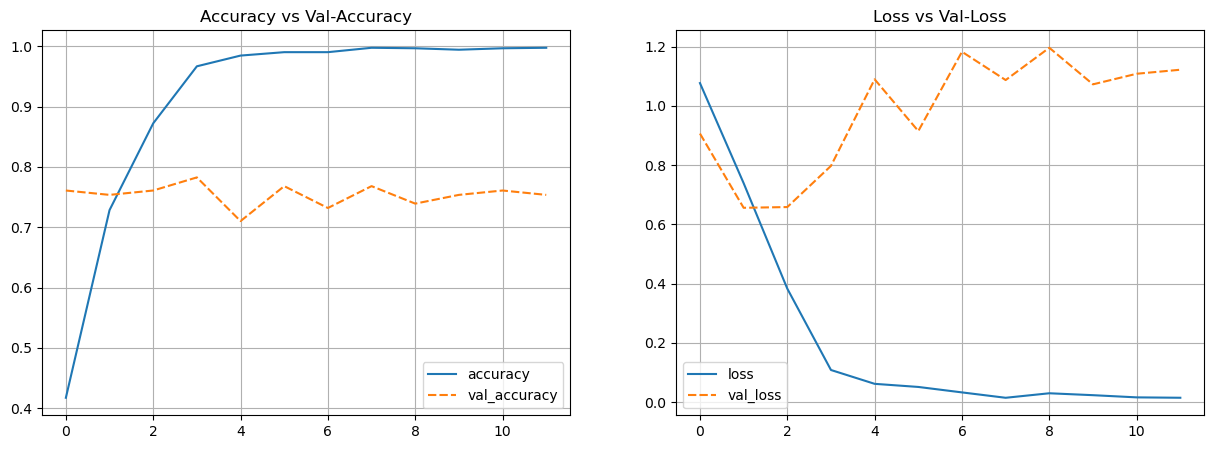

In [45]:
eval(model_lstm_1_hist)

39/39 [==============================] - 1s 3ms/step


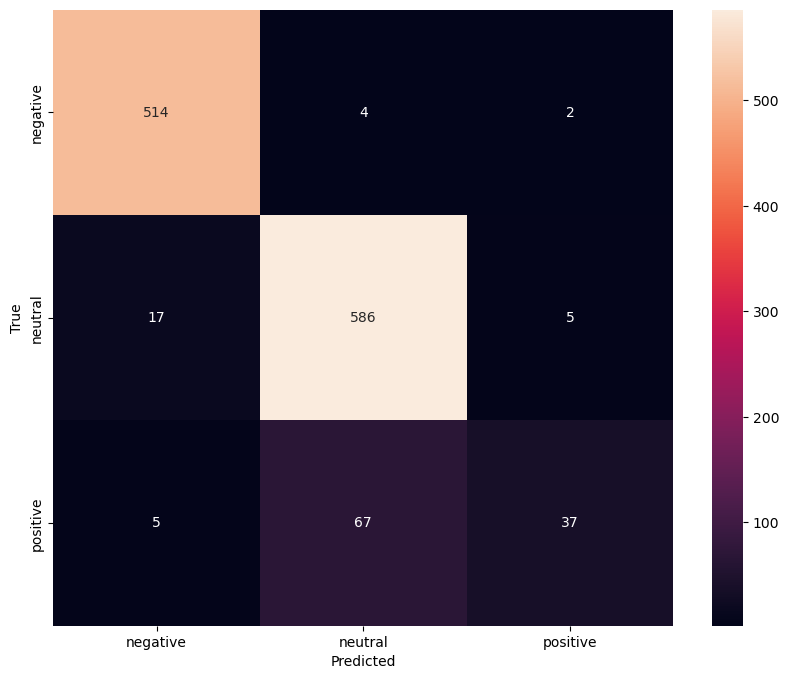

In [46]:
confusion_matrix_plot(model_lstm_1, X_train, y_train)

8/8 [==============================] - 0s 4ms/step


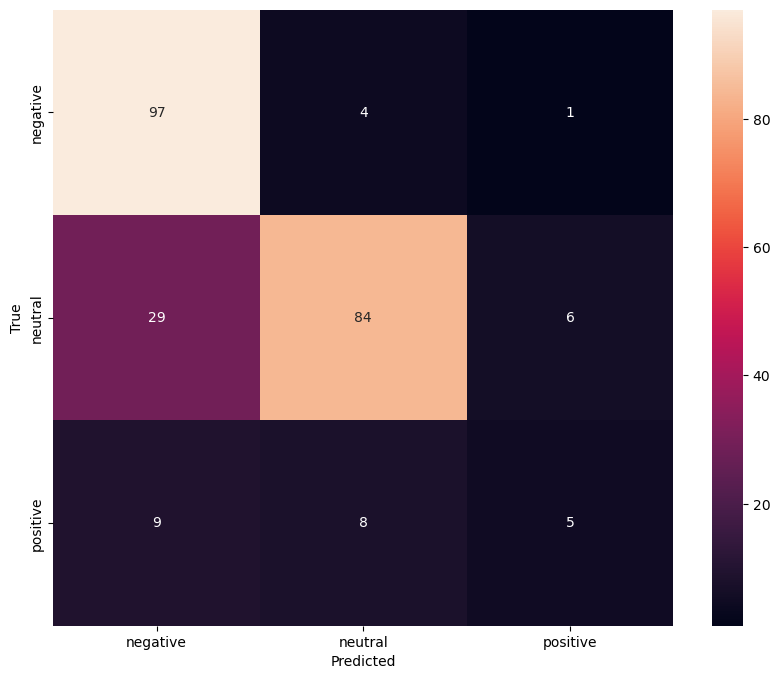

In [47]:
confusion_matrix_plot(model_lstm_1, X_test, y_test)

The LSTM 1 model seems to have learned to distinguish between different sentiments from the text data effectively, but it may benefit from further tuning to address potential overfitting and to improve its ability to generalize, especially for 'positive' sentiments.

## B. LSTM 2

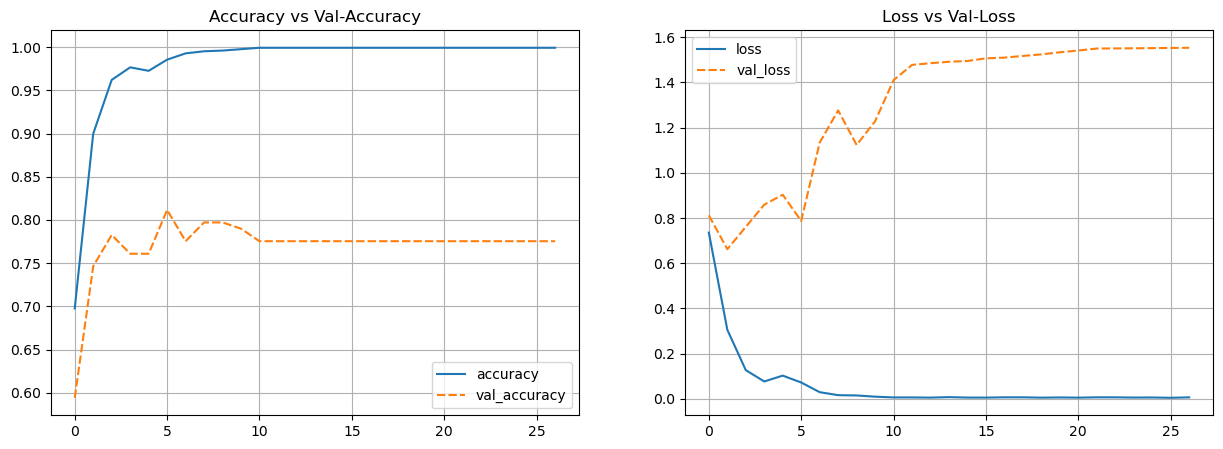

In [48]:
eval(model_lstm_2_hist)

39/39 [==============================] - 1s 17ms/step


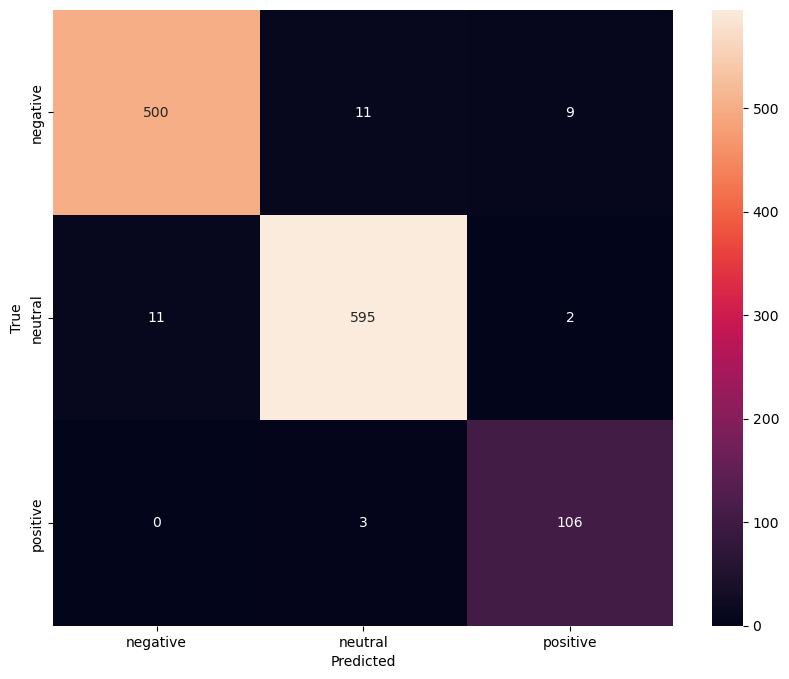

In [49]:
confusion_matrix_plot(model_lstm_2, X_train, y_train)

8/8 [==============================] - 0s 20ms/step


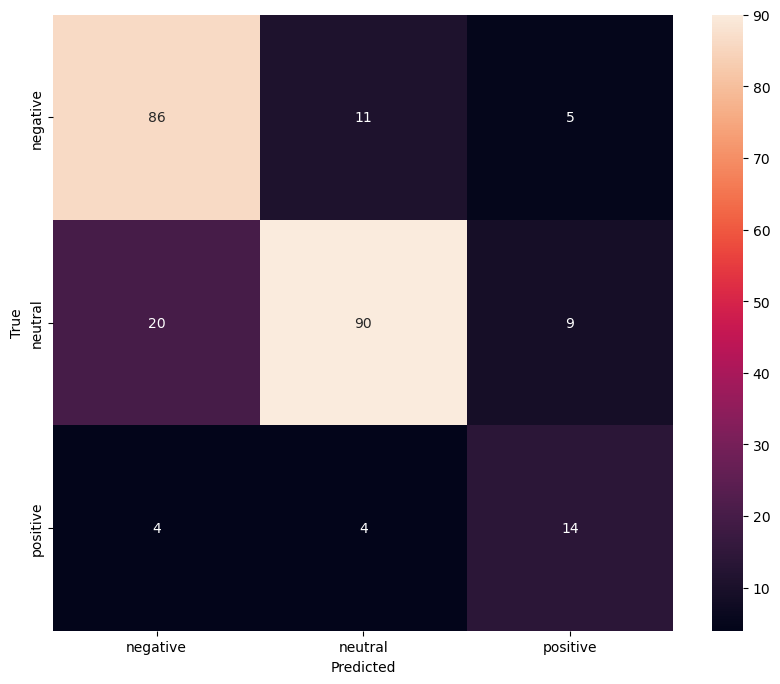

In [50]:
confusion_matrix_plot(model_lstm_2, X_test, y_test)

The LSTM model is good at telling apart both neutral and negative feelings from what people write, but it doesn't do as well with positive feelings, often mixing them up with the other two. This means the model needs to get better at recognizing when people are saying something positive.

## C. Gru

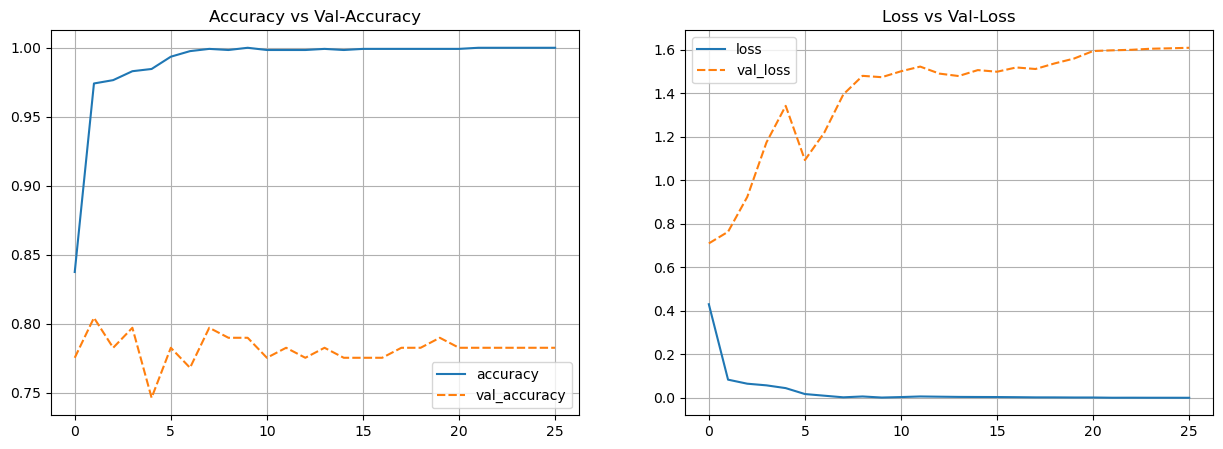

In [51]:
eval(model_gru_hist )

39/39 [==============================] - 1s 15ms/step


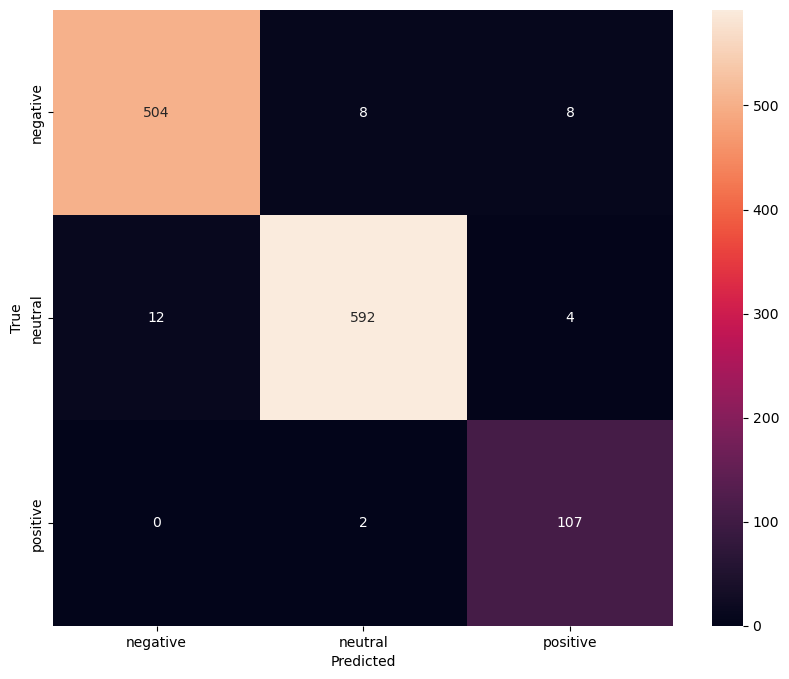

In [52]:
confusion_matrix_plot(model_gru, X_train, y_train)

8/8 [==============================] - 0s 18ms/step


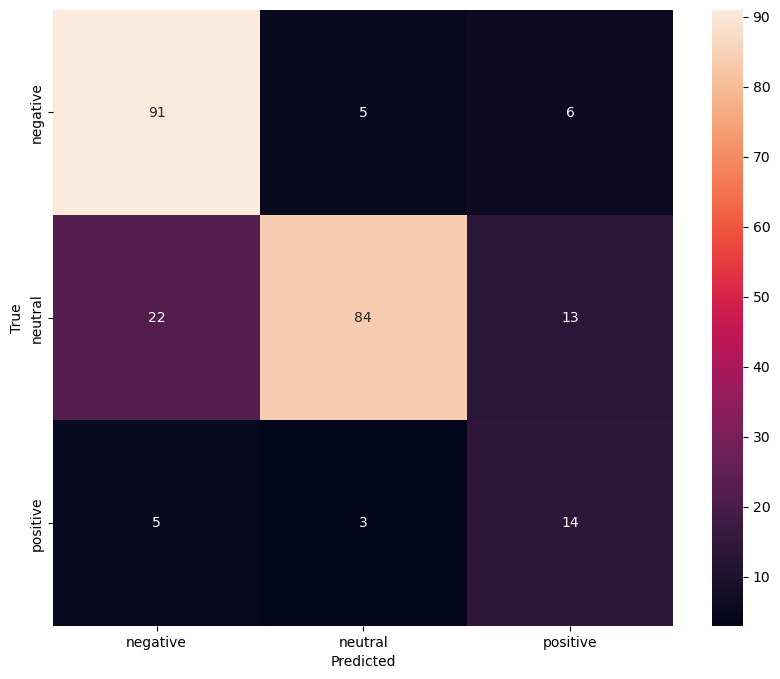

In [53]:
confusion_matrix_plot(model_gru, X_test, y_test)

The GRU model is really good at guessing when comments are neutral or negative but not so good at spotting the positive ones. It also looks like it's learning the training data too well and not doing as great on new, unseen data. We need to tweak the model a bit so it can get better at identifying the positive comments.

# 8. Model Saving

In [54]:
import json
with open('stopwords.txt', 'w') as file:
    json.dump(list(stop_words), file)

The model has been saved with model checkpoints during training, so there is no need to save the model here.

# 9. Model Inference

The model inference will be done on the other notebook `P1G7_Sifra_Inf.ipynb`

# 10. Conclusion

In summary, the dataset analyzed was notably imbalanced, necessitating the application of class weights to ensure a fair representation of all classes during model training. The evaluation encompassed three models: two LSTMs and one GRU. Among these, the second LSTM model exhibited superior performance. Despite being adept at identifying neutral and negative sentiments in text, the model faltered with positive sentiments, frequently confusing them with the other categories. Enhancing the model's ability to accurately recognize positive statements remains a key area for improvement.

# 11. References

https://www.kaggle.com/code/walterlv0/twitter-sentiment-analysis-lstm